# Train a Deep NN to predict Asset Price returns

In practice, we need to explore variations of the design options outlined above because we can rarely be sure from the outset which network architecture best suits the data.

In this section, we will explore various options to build a simple feedforward Neural Network to predict asset price returns for a one-day horizon.

## Imports & Settings

In [57]:
import warnings

from keras.callbacks import TensorBoard
from keras.regularizers import L1L2
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [58]:
%matplotlib inline

import os, sys
from ast import literal_eval as make_tuple
from time import time
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

In [59]:
train_nn = True
ols = True
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [60]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, calculate_splits, reduce_footprint

In [61]:
np.random.seed(42)
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [62]:
results_path = Path('results_D_144_ncut_1yrs')
if not results_path.exists():
    results_path.mkdir()
    
checkpoint_path = results_path / 'logs'

## Create a stock return series to predict asset price moves

To develop our trading strategy, we use the daily stock returns for some 995 US stocks for the eight year period from 2010 to 2017, and the features developed in Chapter 12 that include volatility and momentum factors as well as lagged returns with cross-sectional and sectoral rankings.

In [63]:
multiindex_cols = ['date', 'offset', 'ticker']
data_path = results_path / 'data.ftr'
data = pd.read_feather(data_path).sort_index().set_index(multiindex_cols)
data

rsi   bb_high    bb_low       NATR  \
date       offset ticker                                               
2013-05-03 10     btc-usd   45.195717  0.333876  0.226540  42.895950   
           15     btc-usd   44.996559  0.339432  0.227344  43.202477   
           20     btc-usd   44.665878  0.343619  0.223756  43.594116   
           25     btc-usd   44.785118  0.344467  0.227588  43.588852   
           30     btc-usd   44.907230  0.341647  0.224152  43.305061   
...                               ...       ...       ...        ...   
2021-06-20 865    xtz-usd   37.321785  0.268150 -0.006974  15.573627   
           870    algo-usd  39.315731  0.212823 -0.036147  13.992373   
                  chz-usd   42.134048  0.249972  0.110645  19.293007   
                  leo-usd   47.955723  0.118094  0.078177   8.692143   
                  wbtc-usd  37.396915  0.183451  0.016238  11.874786   

                                 ATR       PPO      MACD  sector       r01  \
date       offset ticker                                                     
2013-05-03 10     btc-usd  -0.460349  4.349795 -0.133858       0 -0.081482   
           15     btc-usd  -0.460884  4.068254 -0.134630       0 -0.065331   
           20     btc-usd  -0.461162  3.673091 -0.135154       0 -0.083011   
           25     btc-usd  -0.461271  3.307914 -0.135503       0 -0.074871   
           30     btc-usd  -0.461130  3.000095 -0.135549       0 -0.077694   
...                              ...       ...       ...     ...       ...   
2021-06-20 865    xtz-usd   1.150429 -6.237974 -1.917071       1 -0.084538   
           870    algo-usd  0.682024  1.954638 -0.619354       0 -0.070389   
                  chz-usd   1.036831  3.956850 -0.538907       2 -0.123368   
                  leo-usd   2.824224  1.499576 -0.429611       2 -0.032668   
                  wbtc-usd  1.280465  1.249398 -1.348212       2 -0.044022   

                                 r02  ...  r03dec  r01q_sector  r02q_sector  \
date       offset ticker              ...                                     
2013-05-03 10     btc-usd  -0.136415  ...     0.0          0.0          1.0   
           15     btc-usd  -0.146862  ...     0.0          0.0          1.0   
           20     btc-usd  -0.142226  ...     0.0          0.0          1.0   
           25     btc-usd  -0.139922  ...     0.0          0.0          1.0   
           30     btc-usd  -0.136460  ...     0.0          0.0          1.0   
...                              ...  ...     ...          ...          ...   
2021-06-20 865    xtz-usd  -0.133996  ...     2.0          1.0          1.0   
           870    algo-usd -0.121663  ...     1.0          1.0          1.0   
                  chz-usd  -0.183621  ...     1.0          0.0          0.0   
                  leo-usd  -0.027579  ...     2.0          2.0          2.0   
                  wbtc-usd -0.093304  ...     2.0          2.0          1.0   

                            r03q_sector   r01_fwd   r02_fwd   r03_fwd  year  \
date       offset ticker                                                      
2013-05-03 10     btc-usd           0.0  0.132056  0.175000  0.125605  2013   
           15     btc-usd           0.0  0.150816  0.179490  0.139388  2013   
           20     btc-usd           0.0  0.158610  0.205149  0.163234  2013   
           25     btc-usd           0.0  0.152595  0.191413  0.162582  2013   
           30     btc-usd           0.0  0.153925  0.192714  0.157307  2013   
...                                 ...       ...       ...       ...   ...   
2021-06-20 865    xtz-usd           2.0 -0.190210 -0.015421 -0.012735  2021   
           870    algo-usd          1.0 -0.174125  0.007268  0.009506  2021   
                  chz-usd           1.0 -0.225372 -0.014524 -0.005949  2021   
                  leo-usd           2.0 -0.051671 -0.003739 -0.010541  2021   
                  wbtc-usd          2.0 -0.083188  0.041487  0.058541  2021   

                          

In [64]:
group_levels = ['offset', 'ticker']
data.groupby(group_levels).count()

rsi  bb_high  bb_low  NATR   ATR   PPO  MACD  sector   r01  \
offset ticker                                                                  
0      algo-usd   698      698     698   698   698   698   698     698   698   
       amp-usd    692      692     692   692   692   692   692     692   692   
       atom-usd   755      755     755   755   755   755   755     755   755   
       bat-usd   1227     1227    1227  1227  1227  1227  1227    1227  1227   
       bnt-usd   1014     1014    1014  1014  1014  1014  1014    1014  1014   
...               ...      ...     ...   ...   ...   ...   ...     ...   ...   
1435   xlm-usd   1114     1114    1114  1114  1114  1114  1114    1114  1114   
       xmr-usd   1631     1631    1631  1631  1631  1631  1631    1631  1631   
       xrp-usd   1461     1461    1461  1461  1461  1461  1461    1461  1461   
       xtz-usd    956      956     956   956   956   956   956     956   956   
       zec-usd   1663     1663    1663  1663  1663  1663  1663    1663  1663   

                  r02  ...  r03dec  r01q_sector  r02q_sector  r03q_sector  \
offset ticker          ...                                                  
0      algo-usd   698  ...     698          698          698          698   
       amp-usd    692  ...     692          692          692          692   
       atom-usd   755  ...     755          755          755          755   
       bat-usd   1227  ...    1227         1227         1227         1227   
       bnt-usd   1014  ...    1014         1014         1014         1014   
...               ...  ...     ...          ...          ...          ...   
1435   xlm-usd   1114  ...    1114         1114         1114         1114   
       xmr-usd   1631  ...    1631         1631         1631         1631   
       xrp-usd   1461  ...    1461         1461         1461         1461   
       xtz-usd    956  ...     956          956          956          956   
       zec-usd   1663  ...    1663         1663         1663         1663   

                 r01_fwd  r02_fwd  r03_fwd  year  month  weekday  
offset ticker                                                     
0      algo-usd      698      698      698   698    698      698  
       amp-usd       692      692      692   692    692      692  
       atom-usd      755      755      755   755    755      755  
       bat-usd      1227     1227     1227  1227   1227     1227  
       bnt-usd      1014     1014     1014  1014   1014     1014  
...                  ...      ...      ...   ...    ...      ...  
1435   xlm-usd      1114     1114     1114  1114   1114     1114  
       xmr-usd      1631     1631     1631  1631   1631     1631  
       xrp-usd      1461     1461     1461  1461   1461     1461  
       xtz-usd       956      956      956   956    956      956  
       zec-usd      1663     1663     1663  1663   1663     1663  

[9216 rows x 23 columns]

In [65]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11211158 entries, (Timestamp('2013-05-03 00:00:00'), 10, 'btc-usd') to (Timestamp('2021-06-20 00:00:00'), 870, 'wbtc-usd')
Data columns (total 23 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   rsi          11211158 non-null  float32
 1   bb_high      11211158 non-null  float32
 2   bb_low       11211158 non-null  float32
 3   NATR         11211158 non-null  float32
 4   ATR          11211158 non-null  float32
 5   PPO          11211158 non-null  float32
 6   MACD         11211158 non-null  float32
 7   sector       11211158 non-null  int16  
 8   r01          11211158 non-null  float32
 9   r02          11211158 non-null  float32
 10  r03          11211158 non-null  float32
 11  r01dec       11211158 non-null  float32
 12  r02dec       11211158 non-null  float32
 13  r03dec       11211158 non-null  float32
 14  r01q_sector  11211158 non-null  float32
 15  r02q_sector  11211158 no

In [66]:
dates= data.index.get_level_values('date')
dates.min(), dates.max()

(Timestamp('2013-05-03 00:00:00'), Timestamp('2021-06-20 00:00:00'))

In [67]:
outcomes = data.filter(like='fwd').columns.tolist()

In [68]:
lookahead = 1
outcome = f'r{lookahead:02}_fwd'

In [69]:
data = data.swaplevel().sort_index()

In [70]:
X_cv = data.drop(outcomes, axis=1)
y_cv = data[outcome]
X_cv.shape, y_cv.shape
#X_cv = data.loc[idx[:, :'2021-3'], :].drop(outcomes, axis=1)
#y_cv = data.loc[idx[:, :'2021-3'], outcome]
#X_cv = data.loc[idx[:, :], :].drop(outcomes, axis=1)
#y_cv = data.loc[idx[:, :], outcome]

((11211158, 20), (11211158,))

In [71]:
X_cv

rsi   bb_high    bb_low       NATR       ATR  \
date       ticker  offset                                                       
2013-05-03 btc-usd 10      45.195717  0.333876  0.226540  42.895950 -0.460349   
                   15      44.996559  0.339432  0.227344  43.202477 -0.460884   
                   20      44.665878  0.343619  0.223756  43.594116 -0.461162   
                   25      44.785118  0.344467  0.227588  43.588852 -0.461271   
                   30      44.907230  0.341647  0.224152  43.305061 -0.461130   
...                              ...       ...       ...        ...       ...   
2021-06-20 zec-usd 835     33.784706  0.279171 -0.004635  17.435909 -0.095235   
                   840     33.533627  0.276957  0.000840  17.326042 -0.095561   
                   845     34.178932  0.272546  0.006203  17.195267 -0.096032   
                   850     34.290592  0.278250 -0.000492  17.421122 -0.095584   
                   855     34.325436  0.276293  0.006249  17.318190 -0.095958   

                                PPO      MACD  sector       r01       r02  \
date       ticker  offset                                                   
2013-05-03 btc-usd 10      4.349795 -0.133858       0 -0.081482 -0.136415   
                   15      4.068254 -0.134630       0 -0.065331 -0.146862   
                   20      3.673091 -0.135154       0 -0.083011 -0.142226   
                   25      3.307914 -0.135503       0 -0.074871 -0.139922   
                   30      3.000095 -0.135549       0 -0.077694 -0.136460   
...                             ...       ...     ...       ...       ...   
2021-06-20 zec-usd 835    -7.518497 -0.527340       2 -0.087386 -0.148134   
                   840    -7.617944 -0.528555       2 -0.083306 -0.144065   
                   845    -7.703447 -0.531402       2 -0.073279 -0.139836   
                   850    -7.770775 -0.530312       2 -0.080260 -0.152268   
                   855    -7.946272 -0.532770       2 -0.081254 -0.149265   

                                r03  r01dec  r02dec  r03dec  r01q_sector  \
date       ticker  offset                                                  
2013-05-03 btc-usd 10     -0.290516     0.0     1.0     0.0          0.0   
                   15     -0.299099     0.0     1.0     0.0          0.0   
                   20     -0.305536     0.0     1.0     0.0          0.0   
                   25     -0.299380     0.0     1.0     0.0          0.0   
                   30     -0.297930     0.0     1.0     0.0          0.0   
...                             ...     ...     ...     ...          ...   
2021-06-20 zec-usd 835    -0.177211     1.0     1.0     0.0          1.0   
                   840    -0.173532     1.0     1.0     0.0          1.0   
                   845    -0.170019     1.0     1.0     0.0          1.0   
                   850    -0.178396     1.0     0.0     0.0          1.0   
                   855    -0.168296     1.0     1.0     0.0          1.0   

                           r02q_sector  r03q_sector  year  month  weekday  
date       ticker  offset                                                  
2013-05-03 btc-usd 10              1.0          0.0  2013      5        4  
                   15              1.0          0.0  2013      5        4  
                   20              1.0          0.0  2013      5        4  
                   25              1.0          0.0  2013      5        4  
                   30              1.0          0.0  2013      5        4  
...                                ...          ...   ...    ...      ...  
2021-06-20 zec-usd 835             1.0          0.0  2021      6        6  
                   840             1.0          0.0  2021      6        6  
                   845             1.0          0.0  2021      6        6  
                   850             0.0          0.0  2021      6        6  
                   855             1.0          0.0  2021      6        6  


In [72]:
len(X_cv.index.get_level_values('ticker').unique())

32

In [73]:
X_cv.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11211158 entries, (Timestamp('2013-05-03 00:00:00'), 'btc-usd', 10) to (Timestamp('2021-06-20 00:00:00'), 'zec-usd', 855)
Data columns (total 20 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   rsi          11211158 non-null  float32
 1   bb_high      11211158 non-null  float32
 2   bb_low       11211158 non-null  float32
 3   NATR         11211158 non-null  float32
 4   ATR          11211158 non-null  float32
 5   PPO          11211158 non-null  float32
 6   MACD         11211158 non-null  float32
 7   sector       11211158 non-null  int16  
 8   r01          11211158 non-null  float32
 9   r02          11211158 non-null  float32
 10  r03          11211158 non-null  float32
 11  r01dec       11211158 non-null  float32
 12  r02dec       11211158 non-null  float32
 13  r03dec       11211158 non-null  float32
 14  r01q_sector  11211158 non-null  float32
 15  r02q_sector  11211158 non

## Automate model generation

The following `make_model` function illustrates how to flexibly define various architectural elements for the search process. The dense_layers argument defines both the depth and width of the network as a list of integers. We also use dropout for regularization, expressed as a float in the range [0, 1] to define the probability that a given unit will be excluded from a training iteration.

In [74]:
def make_model(dense_layers, activation, dropout, reg_L1, reg_L2):
    '''Creates a multi-layer perceptron model

    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=X_cv.shape[1],
                            activity_regularizer=L1L2(reg_L1, reg_L2)))
        else:
            model.add(Dense(layer_size,
                            activity_regularizer=L1L2(reg_L1, reg_L2)))
        model.add(Activation(activation))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='Adam')

    return model

## Cross-validate multiple configurations with TensorFlow

### Train-Test Split

We split the data into a training set for cross-validation, and keep the last 12 months with data as holdout test:

In [75]:
n_datetimes = X_cv.unstack(group_levels).index.nunique()
n_datetimes_y = y_cv.unstack(group_levels).index.nunique()
assert n_datetimes == n_datetimes_y

In [76]:
n_splits = int(3.5*6-2)
train_test_ratio = 6


n_splits = 20

train_test_ratio = 20

train_period_length, test_period_length = calculate_splits(X_cv, lookahead=lookahead,
                                                           train_test_ratio=train_test_ratio,
                                                           n_splits=n_splits,
                                                           unstack=group_levels)

train_period_length, test_period_length

unstack ['offset', 'ticker']
Duplicate index: 


(1399, 69)

In [77]:
train_period_length/8**4

0.341552734375

In [78]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)


### Define CV Parameters

Now we just need to define our Keras classifier using the make_model function, set cross-validation (see chapter 6 on The Machine Learning Process and following for the OneStepTimeSeriesSplit), and the parameters that we would like to explore. 

We pick several one- and two-layer configurations, relu and tanh activation functions, and different dropout rates. We could also try out different optimizers (but did not run this experiment to limit what is already a computationally intensive effort):


Parametersearch:
Best results over 4 years with half a year of training
    -{'dense_layers': '(256, 128)', 'activation': 'tanh', 'dropout': 0.75, 'batch_size': 512, 'epoch': 49}
    -{'dense_layers': '(256, 128)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 512, 'epoch': 43}
    -{'dense_layers': '(256, 128)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 512, 'epoch': 45}
    -{'dense_layers': '(256, 128)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 512, 'epoch': 40}
    -{'dense_layers': '(256, 128)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 512, 'epoch': 46}
    -{'dense_layers': '(128, 64)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 512, 'epoch': 44}
    -{'dense_layers': '(128, 64)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 512, 'epoch': 45}
    -{'dense_layers': '(128, 128)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 512, 'epoch': 36}
    -{'dense_layers': '(128, 128)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 512, 'epoch': 39}
    -{'dense_layers': '(128, 128)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 512, 'epoch': 41}


5 min data:

"""
dense_layer_opts = [(512, 256), (256, 128),
                    (128, 64),  (128, 128)] # best before 64, 64 auf anderen Daten?
# dense_layer_opts = [(128, 64)]
activation_opts = ['relu', 'tanh'] # best relu?
dropout_opts = [.25, 0.5, 0.75]


best layers
{'dense_layers': '(512, 256)', 'activation': 'relu', 'dropout': 0.75, 'batch_size': 1024, 'epoch': 6}
{'dense_layers': '(512, 256)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 1024, 'epoch': 8}
{'dense_layers': '(512, 256)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 1024, 'epoch': 9}
{'dense_layers': '(128, 128)', 'activation': 'relu', 'dropout': 0.25, 'batch_size': 1024, 'epoch': 9}
{'dense_layers': '(256, 128)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'epoch': 9}
{'dense_layers': '(512, 256)', 'activation': 'tanh', 'dropout': 0.5, 'batch_size': 1024, 'epoch': 9}
{'dense_layers': '(256, 128)', 'activation': 'relu', 'dropout': 0.75, 'batch_size': 1024, 'epoch': 7}
{'dense_layers': '(512, 256)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'epoch': 7}
{'dense_layers': '(512, 256)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'epoch': 9}
{'dense_layers': '(512, 256)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'epoch': 8}


In [79]:
"""
dense_layer_opts = [(32, 16), (32, 32),
                    (64, 64), (128, 64),
                    (128, 128), (128, 64),
                    (256, 256), (256, 128)]
activation_opts = ['tanh', 'relu']
dropout_opts = [0.25, 0.5, 0.75]
"""

dense_layer_opts = [(256, 128),
                    (128, 64),
                    (64, 32),
                    (32, 16)]
activation_opts = ['relu']
dropout_opts = [0.25, 0.5]
reg_L1_opts = [0]
reg_L2_opts = [0]


In [80]:
param_grid = list(product(dense_layer_opts, activation_opts, dropout_opts,
                          reg_L1_opts, reg_L2_opts))

np.random.shuffle(param_grid)

In [81]:
len(param_grid)

8

To trigger the parameter search, we instantiate a GridSearchCV object, define the fit_params that will be passed to the Keras model’s fit method, and provide the training data to the GridSearchCV fit method:

In [82]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    return x_train, y_train, x_val, y_val

print('x_cv dates {}:{}'.format(X_cv.index.get_level_values('date').min(),
                                 X_cv.index.get_level_values('date').max()))
dates = []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X_cv)):
    x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, X_cv, train_idx, test_idx)
    date = {}
    date['train_date_min'] = x_train.index.get_level_values('date').min()
    date['train_date_max'] = x_train.index.get_level_values('date').max()
    date['val_date_min'] = x_val.index.get_level_values('date').min()
    date['val_date_max'] = x_val.index.get_level_values('date').max()
    date['train_idx'] = train_idx
    date['test_idx'] = test_idx
    dates.append(date)

    print("train dates {} to {}".format(date['train_date_min'],
                                     date['train_date_max']))

    print("val dates   {} {}".format(date['val_date_min'],
                                     date['val_date_max']))

    print("t duration {}".format(date['train_date_max']-date['train_date_min'] ))
    print("vduration {}".format(date['val_date_max']-date['val_date_min'] ))



x_cv dates 2013-05-03 00:00:00:2021-06-20 00:00:00
train dates 2017-06-14 00:00:00 to 2021-04-12 00:00:00
val dates   2021-04-13 00:00:00 2021-06-20 00:00:00
t duration 1398 days 00:00:00
vduration 68 days 00:00:00
train dates 2017-04-06 00:00:00 to 2021-02-02 00:00:00
val dates   2021-02-03 00:00:00 2021-04-12 00:00:00
t duration 1398 days 00:00:00
vduration 68 days 00:00:00
train dates 2017-01-27 00:00:00 to 2020-11-25 00:00:00
val dates   2020-11-26 00:00:00 2021-02-02 00:00:00
t duration 1398 days 00:00:00
vduration 68 days 00:00:00
train dates 2016-11-19 00:00:00 to 2020-09-17 00:00:00
val dates   2020-09-18 00:00:00 2020-11-25 00:00:00
t duration 1398 days 00:00:00
vduration 68 days 00:00:00
train dates 2016-09-11 00:00:00 to 2020-07-10 00:00:00
val dates   2020-07-11 00:00:00 2020-09-17 00:00:00
t duration 1398 days 00:00:00
vduration 68 days 00:00:00
train dates 2016-06-28 00:00:00 to 2020-05-02 00:00:00
val dates   2020-05-03 00:00:00 2020-07-10 00:00:00
t duration 1404 days 0

In [83]:
X_cv.shape[0]

11211158

In [84]:
early_stop = False

if train_nn:
    tb_callback = TensorBoard(log_dir=results_path / 'tensorboard',
                              histogram_freq=1,
                              write_graph=True,
                              write_images=True)
    ic = []
    scaler = StandardScaler()
    for params in tqdm(param_grid):
        dense_layers, activation, dropout, reg_L1, reg_L2 = params
        for batch_size in [4096*2]:
            print(dense_layers, activation, dropout, batch_size, reg_L1, reg_L2)
            checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(dropout) / str(batch_size) / str(reg_L1) / str(reg_L2)
            if not checkpoint_dir.exists():
                checkpoint_dir.mkdir(parents=True, exist_ok=True)
            start = time()

            for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
                # get train & validation data
                x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)

                # scale features
                x_train = scaler.fit_transform(x_train)
                x_val = scaler.transform(x_val)

                # set up dataframes to log results
                preds = y_val.to_frame('actual')
                r = pd.DataFrame(index=y_val.groupby(level='date').size().index)

                # create model based on validation parameters
                # TODO make a more elaborate way to count len(y)
                model = make_model(dense_layers, activation, dropout,
                                   reg_L1, reg_L2)
                best_ic = -np.inf
                stop = 0

                # cross-validate for x epochs
                for epoch in range(5):

                    model.fit(x_train,
                              y_train,
                              batch_size=batch_size,
                              epochs=1,
                              verbose=0,
                              shuffle=True,
                              validation_data=(x_val, y_val)
                              )

                    model.save_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
                    preds[epoch] = model.predict(x_val).squeeze()
                    r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
                    # print("fold {}".format(fold))
                    ic_approx = float(r[epoch].mean()) + float(r[epoch].median())
                    if ic_approx > best_ic:
                        best_ic = ic_approx*0.95
                        stop = 0
                    else:
                        stop += 1
                    print(f'fold:{fold + 1:02d} | ep:{epoch + 1:03d} | mean_r{r[epoch].mean():7.4f} | med_r{r[epoch].median():7.4f} | stop {stop}')
                    if stop == 3 and early_stop:
                        break
                print("time: {}".format(time()-start))
                ic.append(r.assign(dense_layers=str(dense_layers),
                                   activation=activation,
                                   dropout=dropout,
                                   batch_size=batch_size,
                                   reg_L1=reg_L1,
                                   reg_L2=reg_L2,
                                   fold=fold))

            t = time()-start
            pd.concat(ic).to_hdf(results_path / 'val_scores.h5', 'ic_by_day')



  0%|          | 0/8 [00:00<?, ?it/s]

(256, 128) relu 0.5 8192 0 0
fold:01 | ep:001 | mean_r 0.2303 | med_r 0.2152 | stop 0
fold:01 | ep:002 | mean_r 0.2111 | med_r 0.2092 | stop 1
fold:01 | ep:003 | mean_r 0.1690 | med_r 0.1674 | stop 2
fold:01 | ep:004 | mean_r 0.1563 | med_r 0.1640 | stop 3
fold:01 | ep:005 | mean_r 0.1229 | med_r 0.1489 | stop 4
time: 32.34354257583618
fold:02 | ep:001 | mean_r 0.1443 | med_r 0.1295 | stop 0
fold:02 | ep:002 | mean_r 0.1303 | med_r 0.1075 | stop 1
fold:02 | ep:003 | mean_r 0.1296 | med_r 0.1091 | stop 2
fold:02 | ep:004 | mean_r 0.1044 | med_r 0.1175 | stop 3
fold:02 | ep:005 | mean_r 0.1043 | med_r 0.1149 | stop 4
time: 64.09226036071777
fold:03 | ep:001 | mean_r 0.1584 | med_r 0.1510 | stop 0
fold:03 | ep:002 | mean_r 0.1406 | med_r 0.1273 | stop 1
fold:03 | ep:003 | mean_r 0.1396 | med_r 0.1382 | stop 2
fold:03 | ep:004 | mean_r 0.1136 | med_r 0.1161 | stop 3
fold:03 | ep:005 | mean_r 0.1203 | med_r 0.1292 | stop 4
time: 96.90178084373474
fold:04 | ep:001 | mean_r 0.1653 | med_r 0.1

 12%|█▎        | 1/8 [07:33<52:55, 453.70s/it]

fold:20 | ep:005 | mean_r 0.1215 | med_r 0.1309 | stop 0
time: 453.6862049102783
(64, 32) relu 0.5 8192 0 0
fold:01 | ep:001 | mean_r 0.2273 | med_r 0.2129 | stop 0
fold:01 | ep:002 | mean_r 0.2335 | med_r 0.2061 | stop 0
fold:01 | ep:003 | mean_r 0.2339 | med_r 0.1978 | stop 0
fold:01 | ep:004 | mean_r 0.2314 | med_r 0.2196 | stop 0
fold:01 | ep:005 | mean_r 0.2206 | med_r 0.2042 | stop 1
time: 30.16162419319153
fold:02 | ep:001 | mean_r 0.1720 | med_r 0.1674 | stop 0
fold:02 | ep:002 | mean_r 0.1957 | med_r 0.1898 | stop 0
fold:02 | ep:003 | mean_r 0.1869 | med_r 0.1894 | stop 0
fold:02 | ep:004 | mean_r 0.1860 | med_r 0.1918 | stop 0
fold:02 | ep:005 | mean_r 0.1683 | med_r 0.1901 | stop 1
time: 60.5645489692688
fold:03 | ep:001 | mean_r 0.2038 | med_r 0.2175 | stop 0
fold:03 | ep:002 | mean_r 0.2099 | med_r 0.2316 | stop 0
fold:03 | ep:003 | mean_r 0.1891 | med_r 0.1986 | stop 1
fold:03 | ep:004 | mean_r 0.1753 | med_r 0.1970 | stop 2
fold:03 | ep:005 | mean_r 0.1655 | med_r 0.1553

 25%|██▌       | 2/8 [14:47<44:12, 442.08s/it]

fold:20 | ep:005 | mean_r 0.1283 | med_r 0.1097 | stop 2
time: 433.92142510414124
(256, 128) relu 0.25 8192 0 0
fold:01 | ep:001 | mean_r 0.1653 | med_r 0.1910 | stop 0
fold:01 | ep:002 | mean_r 0.1311 | med_r 0.1427 | stop 1
fold:01 | ep:003 | mean_r 0.1295 | med_r 0.1481 | stop 2
fold:01 | ep:004 | mean_r 0.1601 | med_r 0.1732 | stop 3
fold:01 | ep:005 | mean_r 0.1584 | med_r 0.1647 | stop 4
time: 31.49232769012451
fold:02 | ep:001 | mean_r 0.1450 | med_r 0.1443 | stop 0
fold:02 | ep:002 | mean_r 0.1281 | med_r 0.1297 | stop 1
fold:02 | ep:003 | mean_r 0.1142 | med_r 0.1009 | stop 2
fold:02 | ep:004 | mean_r 0.1088 | med_r 0.1003 | stop 3
fold:02 | ep:005 | mean_r 0.0808 | med_r 0.0727 | stop 4
time: 62.793126344680786
fold:03 | ep:001 | mean_r 0.1276 | med_r 0.1131 | stop 0
fold:03 | ep:002 | mean_r 0.1163 | med_r 0.1124 | stop 1
fold:03 | ep:003 | mean_r 0.1046 | med_r 0.0833 | stop 2
fold:03 | ep:004 | mean_r 0.0813 | med_r 0.0830 | stop 3
fold:03 | ep:005 | mean_r 0.0870 | med_r 

 38%|███▊      | 3/8 [22:16<37:05, 445.11s/it]

fold:20 | ep:005 | mean_r 0.1016 | med_r 0.1191 | stop 1
time: 448.7088544368744
(32, 16) relu 0.5 8192 0 0
fold:01 | ep:001 | mean_r 0.1462 | med_r 0.1220 | stop 0
fold:01 | ep:002 | mean_r 0.1999 | med_r 0.1745 | stop 0
fold:01 | ep:003 | mean_r 0.2209 | med_r 0.1798 | stop 0
fold:01 | ep:004 | mean_r 0.2243 | med_r 0.1984 | stop 0
fold:01 | ep:005 | mean_r 0.2354 | med_r 0.2056 | stop 0
time: 30.140594482421875
fold:02 | ep:001 | mean_r 0.0400 | med_r 0.0566 | stop 0
fold:02 | ep:002 | mean_r 0.1430 | med_r 0.1354 | stop 0
fold:02 | ep:003 | mean_r 0.1715 | med_r 0.1567 | stop 0
fold:02 | ep:004 | mean_r 0.1869 | med_r 0.1896 | stop 0
fold:02 | ep:005 | mean_r 0.1950 | med_r 0.2082 | stop 0
time: 60.395365953445435
fold:03 | ep:001 | mean_r 0.1036 | med_r 0.0858 | stop 0
fold:03 | ep:002 | mean_r 0.1796 | med_r 0.1695 | stop 0
fold:03 | ep:003 | mean_r 0.1891 | med_r 0.1810 | stop 0
fold:03 | ep:004 | mean_r 0.1895 | med_r 0.1792 | stop 0
fold:03 | ep:005 | mean_r 0.1898 | med_r 0.1

 50%|█████     | 4/8 [29:29<29:22, 440.58s/it]

fold:20 | ep:005 | mean_r-0.0316 | med_r-0.0238 | stop 0
time: 433.5955591201782
(128, 64) relu 0.25 8192 0 0
fold:01 | ep:001 | mean_r 0.2083 | med_r 0.1921 | stop 0
fold:01 | ep:002 | mean_r 0.1801 | med_r 0.1721 | stop 1
fold:01 | ep:003 | mean_r 0.1773 | med_r 0.1862 | stop 2
fold:01 | ep:004 | mean_r 0.1406 | med_r 0.1660 | stop 3
fold:01 | ep:005 | mean_r 0.1713 | med_r 0.1847 | stop 4
time: 30.32084822654724
fold:02 | ep:001 | mean_r 0.1637 | med_r 0.1511 | stop 0
fold:02 | ep:002 | mean_r 0.1369 | med_r 0.1318 | stop 1
fold:02 | ep:003 | mean_r 0.1061 | med_r 0.1119 | stop 2
fold:02 | ep:004 | mean_r 0.0784 | med_r 0.0768 | stop 3
fold:02 | ep:005 | mean_r 0.0981 | med_r 0.1070 | stop 4
time: 60.36438846588135
fold:03 | ep:001 | mean_r 0.1704 | med_r 0.1676 | stop 0
fold:03 | ep:002 | mean_r 0.1618 | med_r 0.1693 | stop 0
fold:03 | ep:003 | mean_r 0.1480 | med_r 0.1532 | stop 1
fold:03 | ep:004 | mean_r 0.1303 | med_r 0.1158 | stop 2
fold:03 | ep:005 | mean_r 0.1267 | med_r 0.1

 62%|██████▎   | 5/8 [36:42<21:53, 437.84s/it]

fold:20 | ep:005 | mean_r 0.1411 | med_r 0.1321 | stop 1
time: 432.958477973938
(64, 32) relu 0.25 8192 0 0
fold:01 | ep:001 | mean_r 0.2335 | med_r 0.2261 | stop 0
fold:01 | ep:002 | mean_r 0.2373 | med_r 0.2527 | stop 0
fold:01 | ep:003 | mean_r 0.2183 | med_r 0.2298 | stop 1
fold:01 | ep:004 | mean_r 0.2156 | med_r 0.2429 | stop 2
fold:01 | ep:005 | mean_r 0.2135 | med_r 0.2399 | stop 3
time: 30.25810408592224
fold:02 | ep:001 | mean_r 0.1706 | med_r 0.1364 | stop 0
fold:02 | ep:002 | mean_r 0.1893 | med_r 0.1762 | stop 0
fold:02 | ep:003 | mean_r 0.1932 | med_r 0.1551 | stop 0
fold:02 | ep:004 | mean_r 0.1625 | med_r 0.1563 | stop 1
fold:02 | ep:005 | mean_r 0.1318 | med_r 0.1364 | stop 2
time: 60.34191346168518
fold:03 | ep:001 | mean_r 0.1523 | med_r 0.1391 | stop 0
fold:03 | ep:002 | mean_r 0.1589 | med_r 0.1605 | stop 0
fold:03 | ep:003 | mean_r 0.1516 | med_r 0.1387 | stop 1
fold:03 | ep:004 | mean_r 0.1391 | med_r 0.1422 | stop 2
fold:03 | ep:005 | mean_r 0.1417 | med_r 0.131

 75%|███████▌  | 6/8 [43:55<14:31, 435.96s/it]

fold:20 | ep:005 | mean_r 0.1257 | med_r 0.1321 | stop 0
time: 432.2991986274719
(128, 64) relu 0.5 8192 0 0
fold:01 | ep:001 | mean_r 0.1847 | med_r 0.1614 | stop 0
fold:01 | ep:002 | mean_r 0.2153 | med_r 0.1738 | stop 0
fold:01 | ep:003 | mean_r 0.2173 | med_r 0.2089 | stop 0
fold:01 | ep:004 | mean_r 0.1992 | med_r 0.1858 | stop 1
fold:01 | ep:005 | mean_r 0.1785 | med_r 0.1557 | stop 2
time: 30.22749662399292
fold:02 | ep:001 | mean_r 0.1497 | med_r 0.1578 | stop 0
fold:02 | ep:002 | mean_r 0.1655 | med_r 0.1386 | stop 0
fold:02 | ep:003 | mean_r 0.1527 | med_r 0.1354 | stop 1
fold:02 | ep:004 | mean_r 0.1364 | med_r 0.1411 | stop 2
fold:02 | ep:005 | mean_r 0.1159 | med_r 0.1064 | stop 3
time: 60.064125537872314
fold:03 | ep:001 | mean_r 0.1750 | med_r 0.1740 | stop 0
fold:03 | ep:002 | mean_r 0.1719 | med_r 0.1700 | stop 0
fold:03 | ep:003 | mean_r 0.1501 | med_r 0.1645 | stop 1
fold:03 | ep:004 | mean_r 0.1303 | med_r 0.1297 | stop 2
fold:03 | ep:005 | mean_r 0.1191 | med_r 0.1

 88%|████████▊ | 7/8 [51:08<07:15, 435.16s/it]

fold:20 | ep:005 | mean_r 0.1308 | med_r 0.1566 | stop 0
time: 433.4880735874176
(32, 16) relu 0.25 8192 0 0
fold:01 | ep:001 | mean_r 0.1959 | med_r 0.1524 | stop 0
fold:01 | ep:002 | mean_r 0.2363 | med_r 0.2050 | stop 0
fold:01 | ep:003 | mean_r 0.2416 | med_r 0.2335 | stop 0
fold:01 | ep:004 | mean_r 0.2553 | med_r 0.2447 | stop 0
fold:01 | ep:005 | mean_r 0.2531 | med_r 0.2440 | stop 0
time: 30.285306215286255
fold:02 | ep:001 | mean_r 0.1501 | med_r 0.1470 | stop 0
fold:02 | ep:002 | mean_r 0.1513 | med_r 0.1431 | stop 0
fold:02 | ep:003 | mean_r 0.1604 | med_r 0.1604 | stop 0
fold:02 | ep:004 | mean_r 0.1668 | med_r 0.1716 | stop 0
fold:02 | ep:005 | mean_r 0.1745 | med_r 0.1751 | stop 0
time: 60.5359902381897
fold:03 | ep:001 | mean_r 0.1522 | med_r 0.1147 | stop 0
fold:03 | ep:002 | mean_r 0.1777 | med_r 0.1470 | stop 0
fold:03 | ep:003 | mean_r 0.1720 | med_r 0.1434 | stop 0
fold:03 | ep:004 | mean_r 0.1592 | med_r 0.1564 | stop 0
fold:03 | ep:005 | mean_r 0.1629 | med_r 0.15

100%|██████████| 8/8 [58:22<00:00, 437.80s/it]

fold:20 | ep:005 | mean_r 0.1055 | med_r 0.0827 | stop 0
time: 433.50653076171875


### Evaluate predictive performance

In [85]:
params = ['dense_layers', 'dropout', 'batch_size', 'activation',
          'reg_L1', 'reg_L2']

In [86]:
ic = pd.read_hdf(results_path / 'val_scores.h5', 'ic_by_day')
ic = reduce_footprint(ic)

ic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11040 entries, 2021-04-13 to 2017-11-17
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   0             11040 non-null  float32 
 1   1             11040 non-null  float32 
 2   2             11040 non-null  float32 
 3   3             11040 non-null  float32 
 4   4             11040 non-null  float32 
 5   dense_layers  11040 non-null  category
 6   activation    11040 non-null  category
 7   dropout       11040 non-null  float32 
 8   batch_size    11040 non-null  int16   
 9   reg_L1        11040 non-null  int16   
 10  reg_L2        11040 non-null  int16   
 11  fold          11040 non-null  int16   
dtypes: category(2), float32(6), int16(4)
memory usage: 453.1 KB


In [87]:
ic.groupby(params).size()

dense_layers  dropout  batch_size  activation  reg_L1  reg_L2
(128, 64)     0.25     8192        relu        0       0         1380
              0.50     8192        relu        0       0         1380
(256, 128)    0.25     8192        relu        0       0         1380
              0.50     8192        relu        0       0         1380
(32, 16)      0.25     8192        relu        0       0         1380
              0.50     8192        relu        0       0         1380
(64, 32)      0.25     8192        relu        0       0         1380
              0.50     8192        relu        0       0         1380
dtype: int64

In [88]:
ic_long = pd.melt(ic, id_vars=params + ['fold'], var_name='epoch', value_name='ic')
ic_long = reduce_footprint(ic_long)
ic_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55200 entries, 0 to 55199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   dense_layers  55200 non-null  category
 1   dropout       55200 non-null  float32 
 2   batch_size    55200 non-null  int16   
 3   activation    55200 non-null  category
 4   reg_L1        55200 non-null  int16   
 5   reg_L2        55200 non-null  int16   
 6   fold          55200 non-null  int16   
 7   epoch         55200 non-null  category
 8   ic            55200 non-null  float32 
dtypes: category(3), float32(2), int16(4)
memory usage: 1.0 MB


In [89]:
#ic_long = ic_long.groupby(params+ ['epoch']).ic.mean().to_frame('ic').reset_index()
ic_long = ic_long.groupby(params+ ['epoch', 'fold']).ic.mean().to_frame('ic').reset_index()


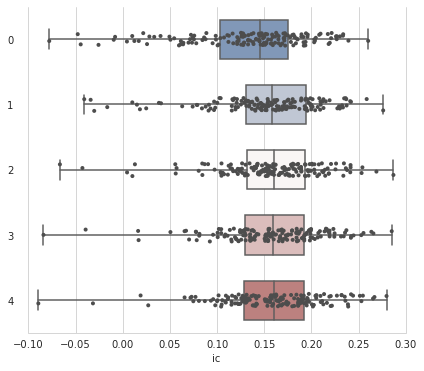

In [90]:
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="ic", y="epoch", data=ic_long,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="ic", y="epoch", data=ic_long,
              size=4, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.savefig(results_path / 'ic_boxplot_epoch.svg', dpi=300)


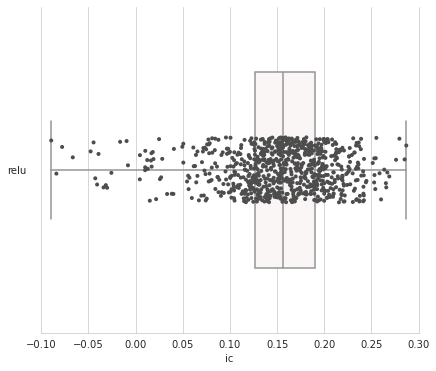

In [91]:
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="ic", y="activation", data=ic_long,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="ic", y="activation", data=ic_long,
              size=4, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.savefig(results_path / 'ic_boxplot_activation.svg', dpi=300)


PosixPath('results_D_144_ncut_1yrs/ic_lineplot_dense_layers_dropout.svg')

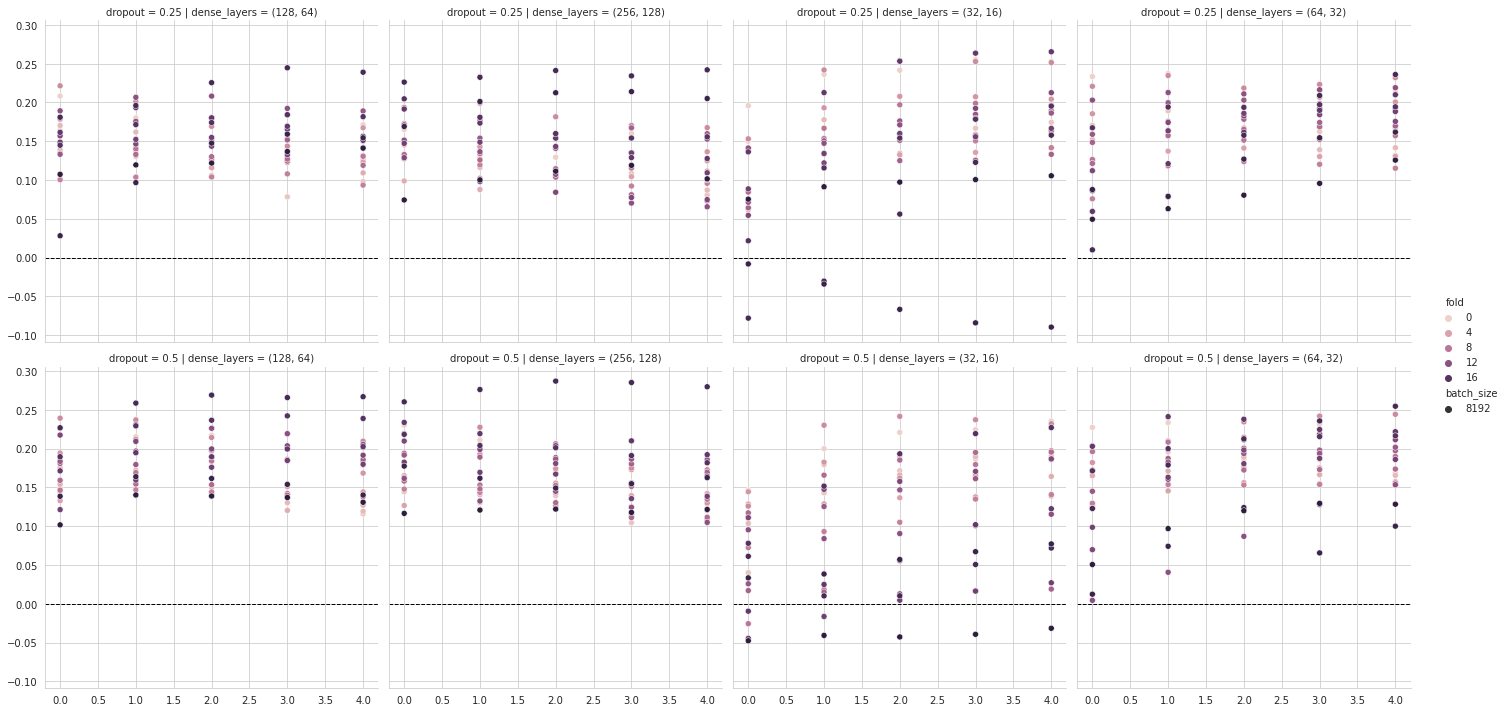

In [92]:
g = sns.relplot(x='epoch', y='ic', col='dense_layers', row='dropout',
                hue='fold', style='batch_size',
                #data=ic_long[ic_long.dropout>0], kind='line')
                data=ic_long, kind='scatter', legend=True)
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig(results_path / 'ic_lineplot_dense_layers_dropout.svg', dpi=300);

results_path / 'ic_lineplot_dense_layers_dropout.svg'



In [93]:
if ols:
    print("1")
    def run_ols(ic):
        ic.dense_layers = ic.dense_layers.str.replace(', ', '-').str.replace('(', '').str.replace(')', '')
        data = pd.melt(ic, id_vars=params, var_name='epoch', value_name='ic')
        data.epoch = data.epoch.astype(int).astype(str).apply(lambda x: f'{int(x):02.0f}')
        model_data = pd.get_dummies(data.sort_values(params + ['epoch']), columns=['epoch'] + params, drop_first=True).sort_index(1)
        model_data.columns = [s.split('_')[-1] for s in model_data.columns]
        model = sm.OLS(endog=model_data.ic, exog=sm.add_constant(model_data.drop('ic', axis=1)), missing='drop')
        return model.fit()

    model = run_ols(ic.drop('fold', axis=1))

    print(model.summary())

1
                            OLS Regression Results                            
Dep. Variable:                     ic   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     67.85
Date:                Fri, 02 Jul 2021   Prob (F-statistic):          1.70e-111
Time:                        19:43:26   Log-Likelihood:                 12795.
No. Observations:               55200   AIC:                        -2.557e+04
Df Residuals:                   55191   BIC:                        -2.549e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1426      0.002     58.179      0

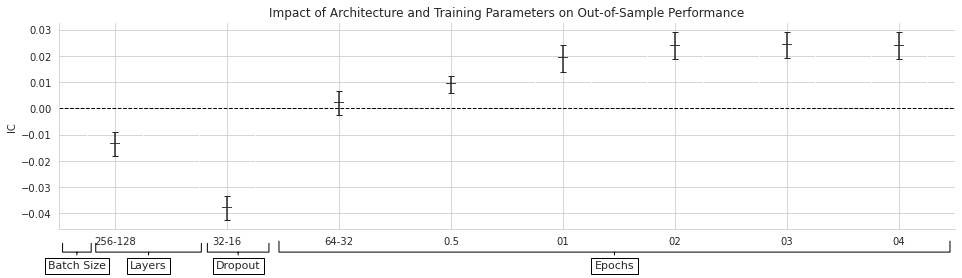

In [94]:
if ols:
    fig, ax = plt.subplots(figsize=(14, 4))

    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]

    coefs.plot(x='variable', y='coef', kind='bar',
               ax=ax, color='none', capsize=3,
               yerr='error', legend=False, rot=0, title='Impact of Architecture and Training Parameters on Out-of-Sample Performance')
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

    ax.annotate('Batch Size', xy=(.02, -0.1), xytext=(.02, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=1.3, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Layers', xy=(.1, -0.1), xytext=(.1, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=4.8, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Dropout', xy=(.2, -0.1), xytext=(.2, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.8, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Epochs', xy=(.62, -0.1), xytext=(.62, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=30.5, lengthB=1.0', lw=1.0, color='black'))

    sns.despine()
    fig.tight_layout()
    fig.savefig(results_path / 'ols_coef', dpi=300)

## Make Predictions



In [95]:

def generate_predictions(dense_layers, activation, dropout, batch_size, reg_L1, reg_L2, epoch):
    # data = pd.read_hdf(data_path, 'model_data').dropna().sort_index()
    # outcomes = data.filter(like='fwd').columns.tolist()
    # X_cv = data.loc[idx[:, :'2021-05'], :].drop(outcomes, axis=1)
    # X_cv = data.drop(outcomes, axis=1)
    # input_dim = X_cv.shape[1]
    # y_cv = data.loc[idx[:, :'2017'], 'r01_fwd']

    scaler = StandardScaler()
    predictions = []
    
    do = '0' if str(dropout) == '0.0' else str(dropout)

    checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(do) / str(batch_size) / str(reg_L1) / str(reg_L2)
        
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
        x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
        x_val = scaler.fit(x_train).transform(x_val)
        """
        print("split {} {}".format(y_val.index.get_level_values('date').min(),
                                   y_val.index.get_level_values('date').max()))
        print("split {} {}".format(dates[fold]['val_date_min'],
                                   dates[fold]['val_date_max']))
        """
        model = make_model(make_tuple(dense_layers), activation, dropout, reg_L1, reg_L2)
        status = model.load_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(x_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [96]:
print(params)

['dense_layers', 'dropout', 'batch_size', 'activation', 'reg_L1', 'reg_L2']


In [97]:
def get_best_params(n=5, ic_given=None):
    """Get the best parameters across all folds by daily median IC"""
    params = ['dense_layers', 'activation', 'dropout', 'batch_size',
              'reg_L1', 'reg_L2']
    if ic_given==None:
        ic = pd.read_hdf(results_path / 'val_scores.h5', 'ic_by_day').drop('fold', axis=1)
    else:
        ic = ic_given
    dates = sorted(ic.index.unique())
    # train_period = 12 * 30 * 24
    train_dates = dates# [:train_period]
    ic = ic.loc[train_dates]
    return (ic.groupby(params)
            .median()
            .stack()
            .to_frame('ic')
            .reset_index()
            .rename(columns={'level_6': 'epoch'})
            .nlargest(n=n, columns='ic')
            .drop('ic', axis=1)
            .to_dict('records'))


In [98]:
best_params = get_best_params()
for param in best_params:
    print(param)
predictions = []
for i, params in enumerate(best_params):
    predictions.append(generate_predictions(**params).to_frame(f'#{i:2}'))

predictions = pd.concat(predictions, axis=1)
predictions.sort_index(inplace=True)
print(predictions.info())

{'dense_layers': '(64, 32)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'epoch': 4}
{'dense_layers': '(128, 64)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'epoch': 2}
{'dense_layers': '(64, 32)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'epoch': 3}
{'dense_layers': '(64, 32)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'epoch': 2}
{'dense_layers': '(256, 128)', 'activation': 'relu', 'dropout': 0.5, 'batch_size': 8192, 'reg_L1': 0, 'reg_L2': 0, 'epoch': 0}
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9893186 entries, (Timestamp('2017-09-10 00:00:00'), 'btc-usd', 0) to (Timestamp('2021-06-20 00:00:00'), 'zec-usd', 855)
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   # 0     float32
 1   # 1     float32
 2   # 2     float32
 3   # 3     float32
 4   # 4     float32
dtypes: float32(5)
memo

In [99]:
predictions.reset_index().to_feather(results_path / 'test_preds.ftr')


In [100]:
targets = y_cv.to_frame('target')
targets.sort_index()
results = predictions.join(targets)
results.reset_index().to_feather(results_path / 'results.ftr')
results


In [101]:
for i, params in tqdm(enumerate(best_params)):
    results[f'ic #{i:2}'] = results.apply(lambda x: spearmanr(x['target'], x[f'#{i:2}'])[0], axis=1)

results

5it [10:29, 125.92s/it]


# 0       # 1       # 2       # 3       # 4  \
date       ticker  offset                                                     
2017-09-10 btc-usd 0       0.011433  0.009906  0.011401  0.010061  0.000118   
                   5       0.013861  0.013701  0.014362  0.014069 -0.001805   
                   10      0.012026  0.010265  0.011952  0.010609  0.000202   
                   15      0.013674  0.018978  0.014521  0.014166  0.002145   
                   20      0.014484  0.018333  0.015262  0.014897  0.000671   
...                             ...       ...       ...       ...       ...   
2021-06-20 zec-usd 835     0.011973  0.012262  0.010922  0.007412 -0.009930   
                   840     0.011633  0.012304  0.010759  0.007464 -0.008326   
                   845     0.011354  0.012382  0.010806  0.007662 -0.007042   
                   850     0.034669  0.017381  0.028578  0.022296  0.017287   
                   855     0.011457  0.012174  0.010581  0.007626 -0.008188   

                             target  ic_# 0  ic_# 1  ic_# 2  ic_# 3  ic_# 4  
date       ticker  offset                                                    
2017-09-10 btc-usd 0      -0.009750     NaN     NaN     NaN     NaN     NaN  
                   5      -0.007795     NaN     NaN     NaN     NaN     NaN  
                   10     -0.007320     NaN     NaN     NaN     NaN     NaN  
                   15     -0.007360     NaN     NaN     NaN     NaN     NaN  
                   20     -0.007249     NaN     NaN     NaN     NaN     NaN  
...                             ...     ...     ...     ...     ...     ...  
2021-06-20 zec-usd 835    -0.206348     NaN     NaN     NaN     NaN     NaN  
                   840    -0.218336     NaN     NaN     NaN     NaN     NaN  
                   845    -0.204219     NaN     NaN     NaN     NaN     NaN  
                   850    -0.202903     NaN     NaN     NaN     NaN     NaN  
                   855    -0.198513     NaN     NaN     NaN     NaN     NaN  

[9893186 rows x 11 columns]

In [102]:
results.reset_index().to_feather(results_path / 'results_IC.ftr')



### How to further improve the results

The relatively simple architecture yields some promising results. To further improve performance, you can
- First and foremost, add new features and more data to the model
- Expand the set of architectures to explore, including more or wider layers
- Inspect the training progress and train for more epochs if the validation error continued to improve at 50 epochs

Finally, you can use more sophisticated architectures, including Recurrent Neural Networks (RNN) and Convolutional Neural Networks that are well suited to sequential data, whereas vanilla feedforward NNs are not designed to capture the ordered nature of the features.
